In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython import display
import PIL
import glob
import imageio 
import random
import math

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
checkpoint_dir = './training_checkpoints'
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

class GansModel():
    
    def __init__(self, shape, prefix):
        self.shape = shape
        self.prefix = prefix
        
    def make_generator_model(self, initial_layer_height, stride_per_layer):
        model = tf.keras.Sequential()
        model.add(Dense(initial_layer_height*initial_layer_height*256, use_bias=False, input_shape=(100,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Reshape((initial_layer_height, initial_layer_height, 256)))
        assert model.output_shape == (None, initial_layer_height, initial_layer_height, 256) # Note: None is the batch size

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert model.output_shape == (None, initial_layer_height, initial_layer_height, 128)
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        
        count = int(math.log10(self.shape[0]/initial_layer_height)/math.log10(2)) - 1
        tempSize = initial_layer_height*stride_per_layer
        numFilters = 128/2
        for i in range(count):
            model.add(Conv2DTranspose(numFilters, (5, 5), strides=(stride_per_layer, stride_per_layer), padding='same', use_bias=False))
            assert model.output_shape == (None, tempSize, tempSize, numFilters)
            model.add(BatchNormalization())
            model.add(LeakyReLU())
            tempSize = tempSize*stride_per_layer
            numFilters = numFilters // 2 
            if numFilters < 1 :
                numFilters = 1
                
        model.add(Conv2DTranspose(self.shape[2], (5, 5), strides=(stride_per_layer, stride_per_layer), padding='same', use_bias=False, activation='tanh'))
        assert model.output_shape == (None, self.shape[0], self.shape[1], self.shape[2])

        return model
    
    def make_discriminator_model(self):
        model = tf.keras.Sequential()

        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[self.shape[0], self.shape[1], self.shape[2]]))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(1))

        return model
    

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    @tf.function
    def train_step(self, images):

        # 1 - Create a random noise to feed it into the model
        # for the image generation
        noise = tf.random.normal([BATCH_SIZE, noise_dim])

        # 2 - Generate images and calculate loss values
        # GradientTape method records operations for automatic differentiation.
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        # 3 - Calculate gradients using loss values and model variables
        # "gradient" method computes the gradient using 
        # operations recorded in context of this tape (gen_tape and disc_tape).

        # It accepts a target (e.g., gen_loss) variable and 
        # a source variable (e.g.,generator.trainable_variables)
        # target --> a list or nested structure of Tensors or Variables to be differentiated.
        # source --> a list or nested structure of Tensors or Variables.
        # target will be differentiated against elements in sources.

        # "gradient" method returns a list or nested structure of Tensors  
        # (or IndexedSlices, or None), one for each element in sources. 
        # Returned structure is the same as the structure of sources.
        gradients_of_generator = gen_tape.gradient(gen_loss, 
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    self.discriminator.trainable_variables)

        # 4 - Process  Gradients and Run the Optimizer
        # "apply_gradients" method processes aggregated gradients. 
        # ex: optimizer.apply_gradients(zip(grads, vars))
        """
        Example use of apply_gradients:
        grads = tape.gradient(loss, vars)
        grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
        # Processing aggregated gradients.
        optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
        """
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss
    
    
    def train(self, dataset, epochs):
      # A. For each epoch, do the following:
        final_loss = {}
        for epoch in range(epochs):
            start = time.time()
            # 1 - For each batch of the epoch, 
            losses = {
                    'loss_gen': [],
                    'loss_disc': []
                }    
            for image_batch in dataset:
                # 1.a - run the custom "train_step" function
                # we just declared above
                gen_loss, disc_loss = self.train_step(image_batch)
                losses['loss_gen'].append(gen_loss)
                losses['loss_disc'].append(disc_loss)
            # 2 - Produce images for the GIF as we go and plot losses
            
            display.clear_output(wait=True)
            plt.plot(losses['loss_gen'], label = "gen_loss")
            plt.plot(losses['loss_disc'], label = "disc_loss")
            plt.legend()
            plt.show()
            self.generate_and_save_images(self.generator,
                                 epoch + 1,
                                 seed)
            final_loss = losses
            # 3 - Save the model every 5 epochs as 
            # a checkpoint, which we will use later
#             if (epoch + 1) % 5 == 0:
#                 self.checkpoint.save(file_prefix = self.checkpoint_prefix)

            # 4 - Print out the completed epoch no. and the time spent
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

            # B. Generate a final image after the training is completed
        display.clear_output(wait=True)
        plt.plot(final_loss['loss_gen'], label = "gen_loss")
        plt.plot(final_loss['loss_disc'], label = "disc_loss")
        plt.legend()
        plt.show()
        plt.savefig('{}_{}_final_losses.png'.format(self.prefix, epochs))
        self.generate_and_save_images(self.generator,
                               epochs,
                               seed)
        
        
    def generate_and_save_images(self, model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        # 1 - Generate images
        predictions = model(test_input, training=False)
        # 2 - Plot the generated images
        fig = plt.figure(figsize=(4,4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            if self.shape[2] == 1 :
                plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            else:
                plt.imshow(predictions[i] * 0.5 + 0.5)
            plt.axis('off')
        # 3 - Save the generated images
        plt.savefig('training_output/{}_image_at_epoch_{:04d}.png'.format(self.prefix, epoch))
        plt.show()
        
    def display_image(self, epoch_no):
        return PIL.Image.open('training_output/{}_image_at_epoch_{:04d}.png'.format(self.prefix, epoch_no))

    
    def create_display_gif(self, epochs):
        anim_file_format=anim_file = 'dcgan_training_{}_{}.gif'
        
        anim_file = anim_file_format.format(self.prefix, epochs)

        with imageio.get_writer(anim_file, mode='I') as writer:
            filenames = glob.glob('training_output/{}_image*.png'.format(self.prefix))
            filenames = sorted(filenames)[:epochs]
            for filename in filenames:
                image = imageio.imread(filename)
                writer.append_data(image)


        return display.Image(open(anim_file,'rb').read())
    
    def use(self, epochs, data, initial_layer_height, stride_per_layer):
        self.generator = self.make_generator_model(initial_layer_height, stride_per_layer)
        noise = tf.random.normal([1, 100])
        self.generated_image = self.generator(noise, training=False)
        self.discriminator = self.make_discriminator_model()
        self.decision = self.discriminator(self.generated_image)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        

#         self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#         self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
#                                          discriminator_optimizer=self.discriminator_optimizer,
#                                          generator=self.generator,
#                                          discriminator=self.discriminator)
        
        start_time = time.time()
        self.train(data, epochs)
        end_time = time.time()

        print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes to train for {epochs} epochs.')

### Using MNIST dataset

In [4]:
(train_images_mnist, train_labels_mnist), (_, _) = tf.keras.datasets.mnist.load_data() 

train_images_mnist = train_images_mnist.reshape(train_images_mnist.shape[0], 28, 28, 1).astype('float32')
train_images_mnist = (train_images_mnist - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset_mnist = tf.data.Dataset.from_tensor_slices(train_images_mnist).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset_mnist

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

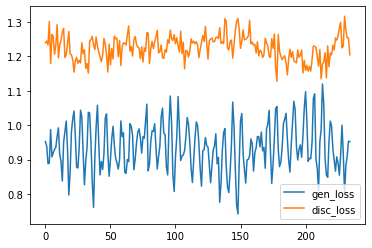

<Figure size 432x288 with 0 Axes>

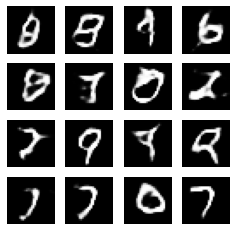

Took 3.8 minutes to train for 50 epochs.


In [10]:
shape = (28, 28, 1)
epochs = 50
initial_layer_height, stride_per_layer = 7, 2
ganModel = GansModel(shape, 'mnist')
ganModel.use(epochs, train_dataset_mnist, initial_layer_height, stride_per_layer)


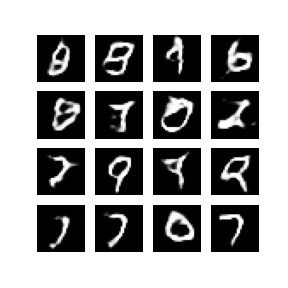

In [11]:
ganModel.display_image(epochs)

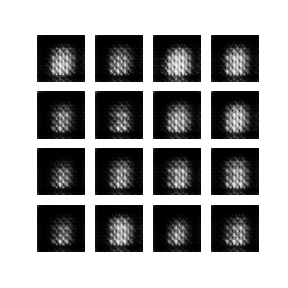

In [12]:
ganModel.create_display_gif(epochs)

# Running on Natural images dataset

In [ ]:
data_dir='natural_images/'
batch_size = 64
img_height = 256
img_width = 256

In [ ]:
def create_dataset_PIL(img_folder):
    
    img_data_array=[]
    class_name=[]
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= np.array(PIL.Image.open(image_path))
            image= np.resize(image,(img_height,img_width,3))
            image = image.astype('float32')
            image = (image -127.5) / 127.5
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array , class_name

In [ ]:
PIL_img_data, class_name=create_dataset_PIL(data_dir)

In [ ]:
plt.imshow(PIL_img_data[0])

In [ ]:


target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

train_dataset_natural_images = tf.data.Dataset.from_tensor_slices(PIL_img_data).shuffle(len(target_val)).batch(batch_size)

train_dataset_natural_images

In [ ]:
shape = (256, 256, 3)
epochs = 20
BATCH_SIZE = 64
initial_layer_height, stride_per_layer = 8, 2
ganModel = GansModel(shape)
ganModel.use(epochs, train_dataset_natural_images, initial_layer_height, stride_per_layer)

# Running CFAR10 dataset from keras

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset

In [ ]:
shape = (32, 32, 3)
epochs = 500
initial_layer_height, stride_per_layer = 8, 2
ganModel = GansModel(shape)
ganModel.use(epochs, train_dataset, initial_layer_height, stride_per_layer)


# Running on Pokemon dataset

In [ ]:
data_dir='pokemon/'
batch_size = 64
img_height = 256
img_width = 256

In [ ]:
pokemon_data, class_name=create_dataset_PIL(data_dir)

# pokemon_data

In [ ]:
plt.imshow(pokemon_data[0])

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(class_name))}
target_val=  [target_dict[class_name[i]] for i in range(len(class_name))]

train_dataset_pokemon = tf.data.Dataset.from_tensor_slices(pokemon_data).shuffle(len(target_val)).batch(batch_size)

train_dataset_pokemon

In [ ]:
shape = (256, 256, 3)
epochs = 20
BATCH_SIZE = 64
initial_layer_height, stride_per_layer = 8, 2
ganModel = GansModel(shape)
ganModel.use(epochs, train_dataset_natural_images, initial_layer_height, stride_per_layer)